In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
 
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
 
import warnings
warnings.filterwarnings('ignore')

This ML Project is about Clustering. Clustering is the process of grouping data points together based on similarity with each other. This is different from Classification as instead of using predetermined labels for the data points, there is none with Clustering, as we let the model make the labels itself. This is essential for situations where this is no target variable. This is also define as Unsupervised Learning, where the model has no labels for its data and must do it itself.

https://www.kaggle.com/datasets/vetrirah/customer?select=Train.csv

The data I am using for this project is from Kaggle about a phone company with details about customers. There is labels for categories but for this project I will be removing them

In [61]:
df = pd.read_csv('Test.csv')
df1 = pd.read_csv('Train.csv')
df = pd.concat([df, df1])
df = df.drop(columns=['Var_1'])

In [62]:
df

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Segmentation
0,458989,Female,Yes,36,Yes,Engineer,0.0,Low,1.0,NaN
1,458994,Male,Yes,37,Yes,Healthcare,8.0,Average,4.0,NaN
2,458996,Female,Yes,69,No,NaN,0.0,Low,1.0,NaN
3,459000,Male,Yes,59,No,Executive,11.0,High,2.0,NaN
4,459001,Female,No,19,No,Marketing,NaN,Low,4.0,NaN
...,...,...,...,...,...,...,...,...,...,...
8063,464018,Male,No,22,No,NaN,0.0,Low,7.0,D
8064,464685,Male,No,35,No,Executive,3.0,Low,4.0,D
8065,465406,Female,No,33,Yes,Healthcare,1.0,Low,1.0,D
8066,467299,Female,No,27,Yes,Healthcare,1.0,Low,4.0,B


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10695 entries, 0 to 8067
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               10695 non-null  int64  
 1   Gender           10695 non-null  object 
 2   Ever_Married     10505 non-null  object 
 3   Age              10695 non-null  int64  
 4   Graduated        10593 non-null  object 
 5   Profession       10533 non-null  object 
 6   Work_Experience  9597 non-null   float64
 7   Spending_Score   10695 non-null  object 
 8   Family_Size      10247 non-null  float64
 9   Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(6)
memory usage: 919.1+ KB


It's seem that theres some null values in here, as there are some columns with value counts less than the total rows. Lets go ahead and get rid of these to prevent issues ahead

In [64]:
df = df.dropna()

In [65]:
df.nunique()

ID                 6718
Gender                2
Ever_Married          2
Age                  67
Graduated             2
Profession            9
Work_Experience      15
Spending_Score        3
Family_Size           9
Segmentation          4
dtype: int64

Fortunately there is no column with only 1 unique value, meaning all of these can used to help the model making decision if needed. If there were only 1 unique value in a column it would have no impact on the model, and should be removed.

Now lets do some visualiations so we can better understand the data and see if there are any correlations to be found within the customers

In [66]:
df['Age'] = df['Age'].astype(float)

floats, objects = [], []
for col in df.columns:
    if df[col].dtype == object:
        objects.append(col)
    elif df[col].dtype == float:
        floats.append(col)



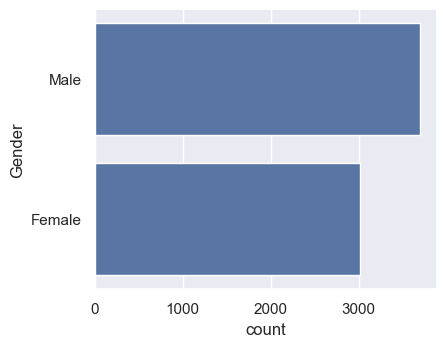

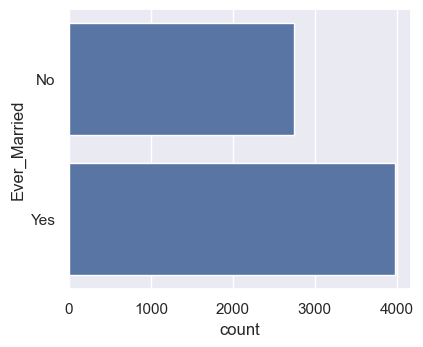

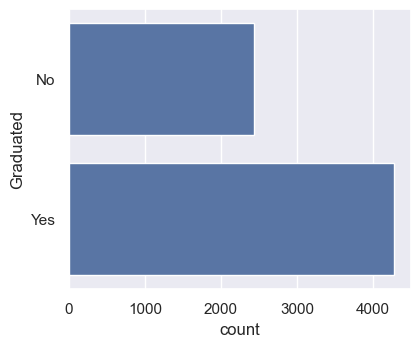

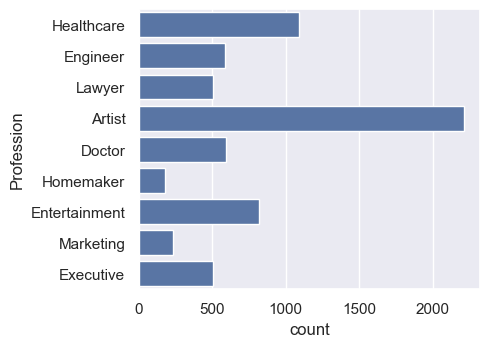

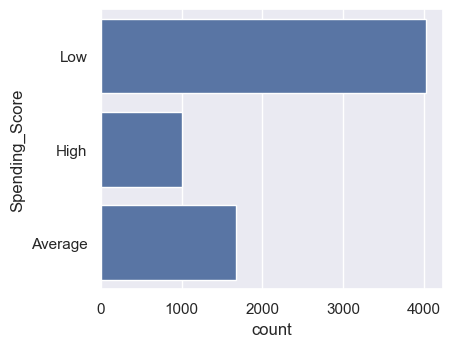

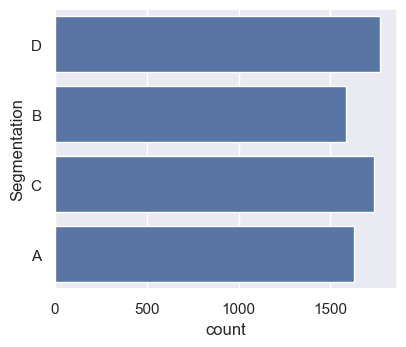

In [67]:
for i, col in enumerate(objects):
    plt.subplot(2, 3, i + 1)
    sb.countplot(df[col])
    plt.show()

Its good to see that the classes for the customers are equally distributed, without any class that it more popular than the other. Lets compare the columns with the Segmentation to see if theres anything else we can look into

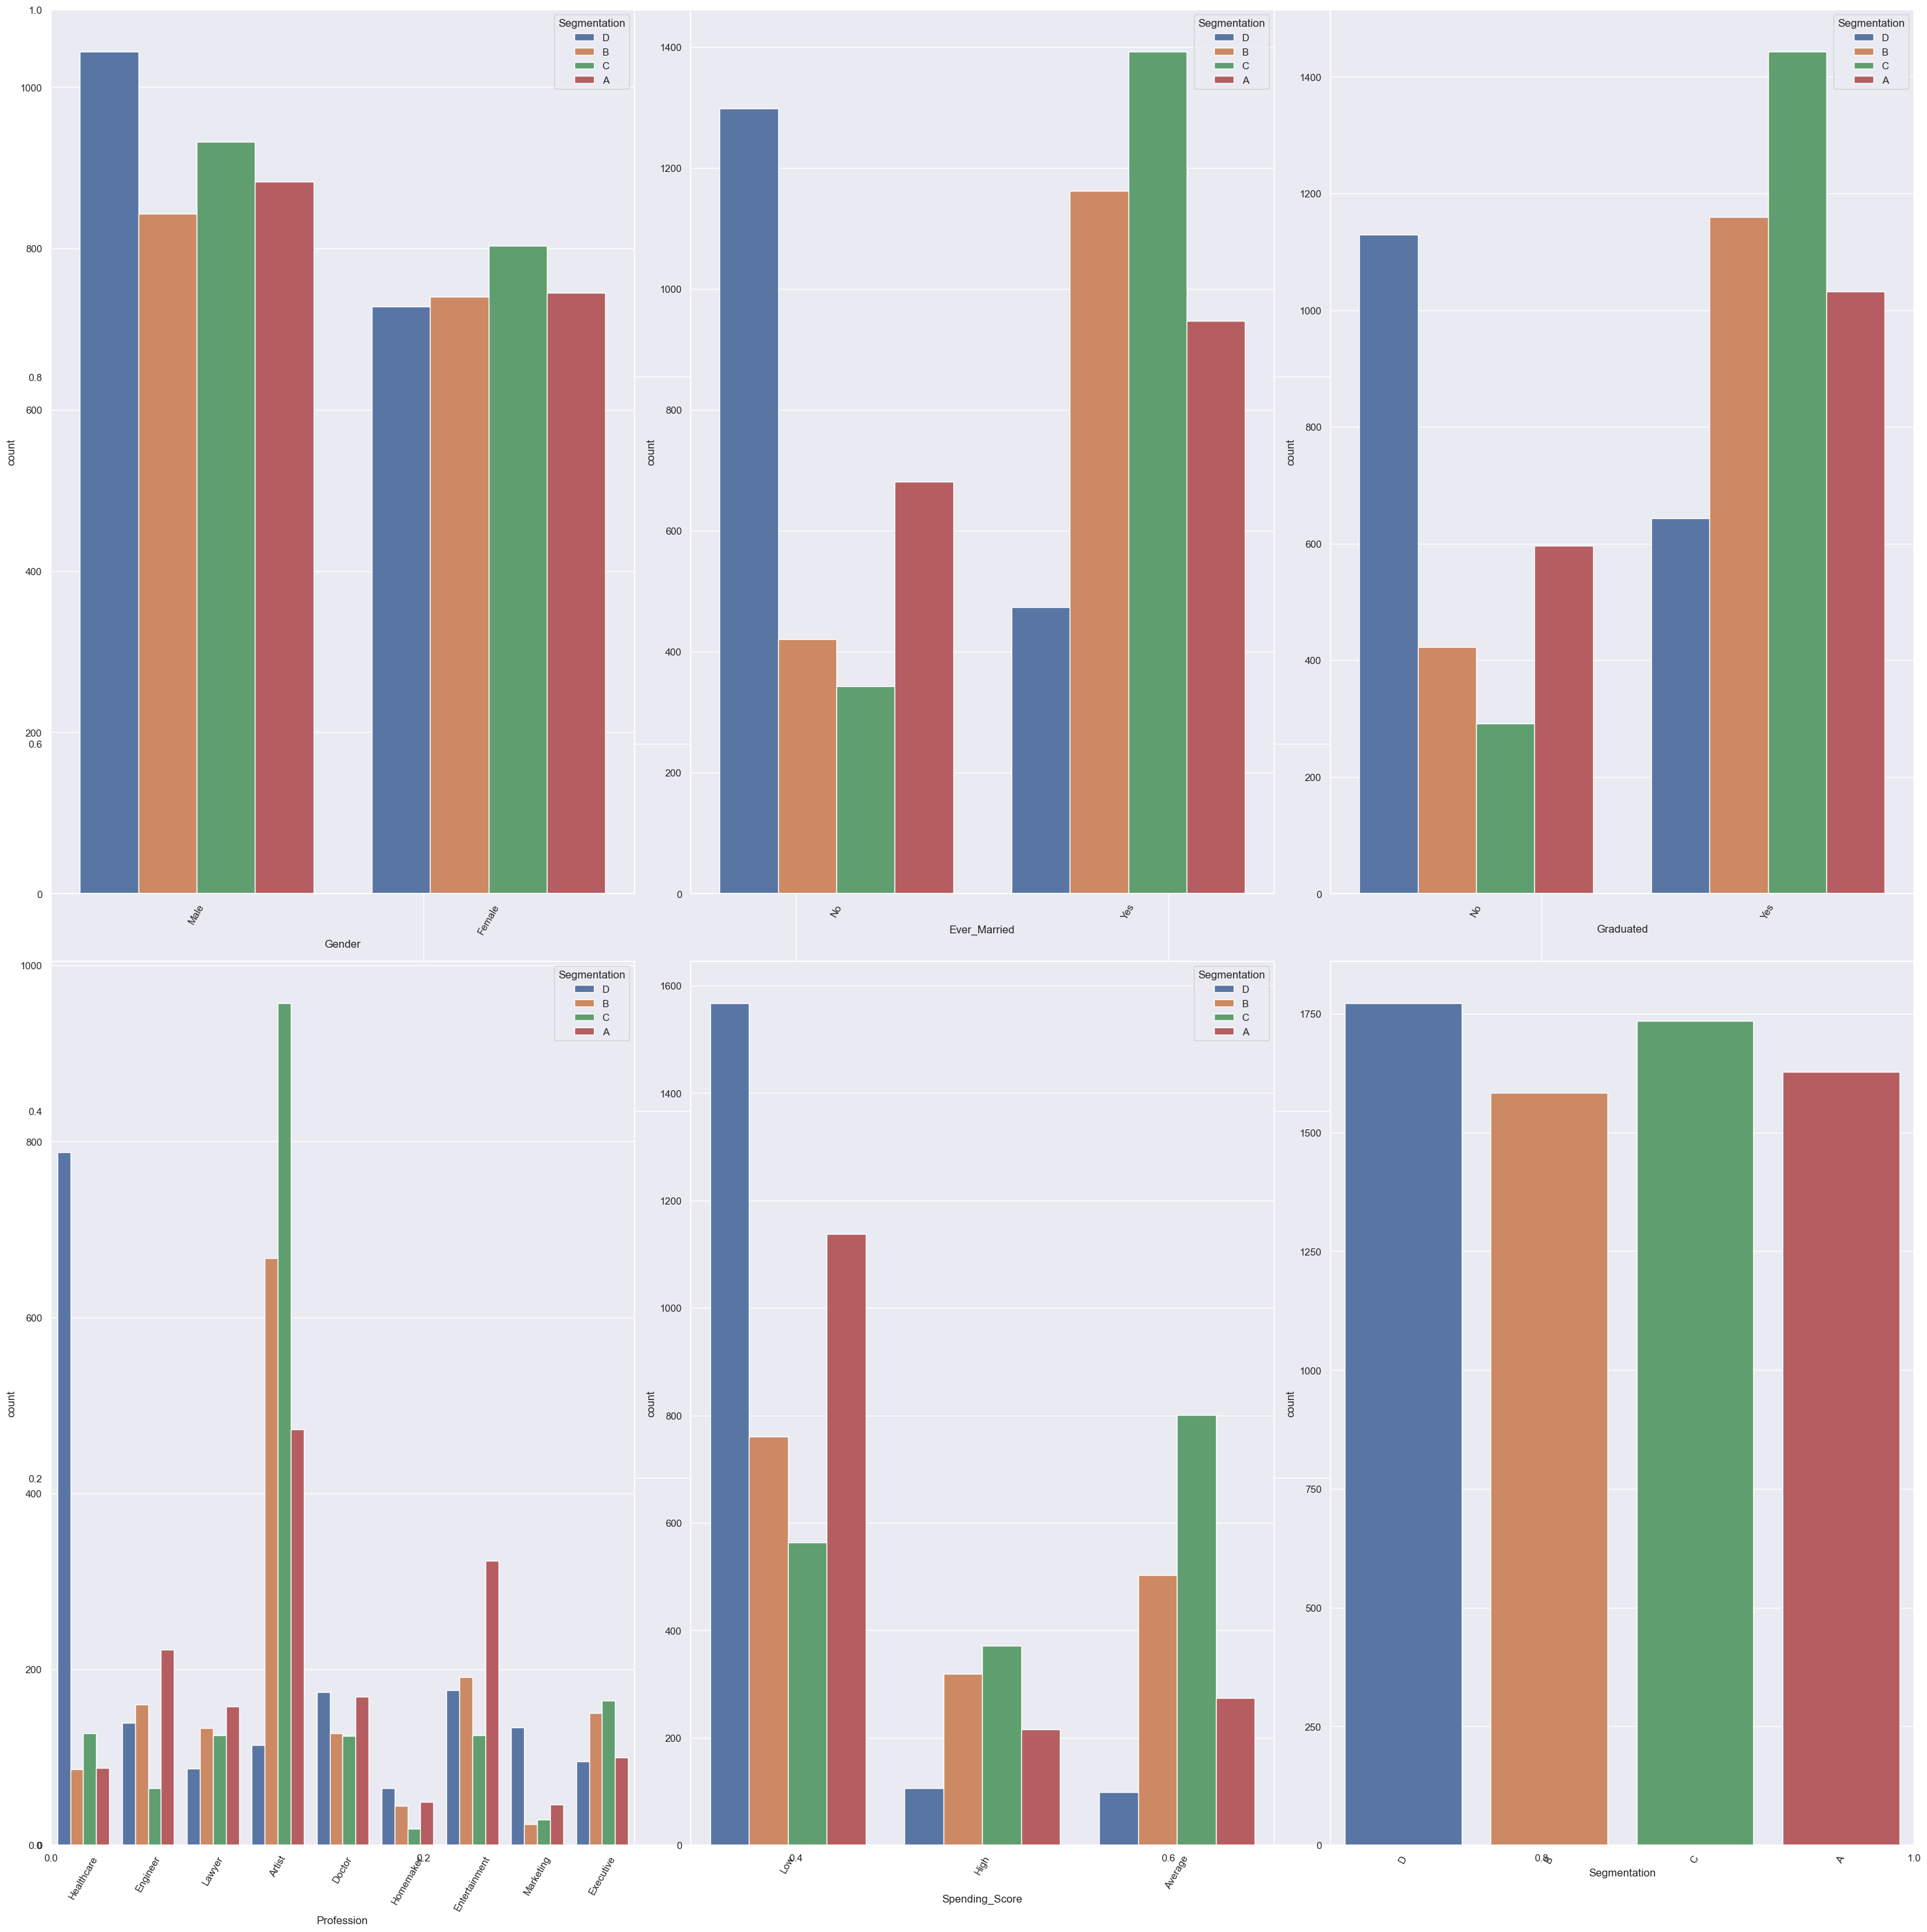

In [68]:
df

plt.subplots(figsize=(30, 30))

for i, col in enumerate(objects):
    plt.subplot(2, 3, i+1)
    sb.countplot(df, x=col, hue='Segmentation')
    plt.xticks(rotation=60)

plt.tight_layout()
plt.show()

When looking at these graphs, we can deduce a few things:

Firstly, there are some segments that can be correlated with spending score. Most notably Class D primarily has a Low spending score, with barely any in the Average/High Score. Red seems to follow the same suit but not as significantly.

When looking at profession, Theres some significance with D and C, with D primarily being in Healthcare and C in Artistry. It's strange that people in the healthcare industry (which has high paying jobs) has a low spending score on average. C Makes some sense as from my knowledge art supplies, such as paint, brushes, etc are somewhat expensive, and that is conveyed in the spending score, where C had an Average/High spending score.



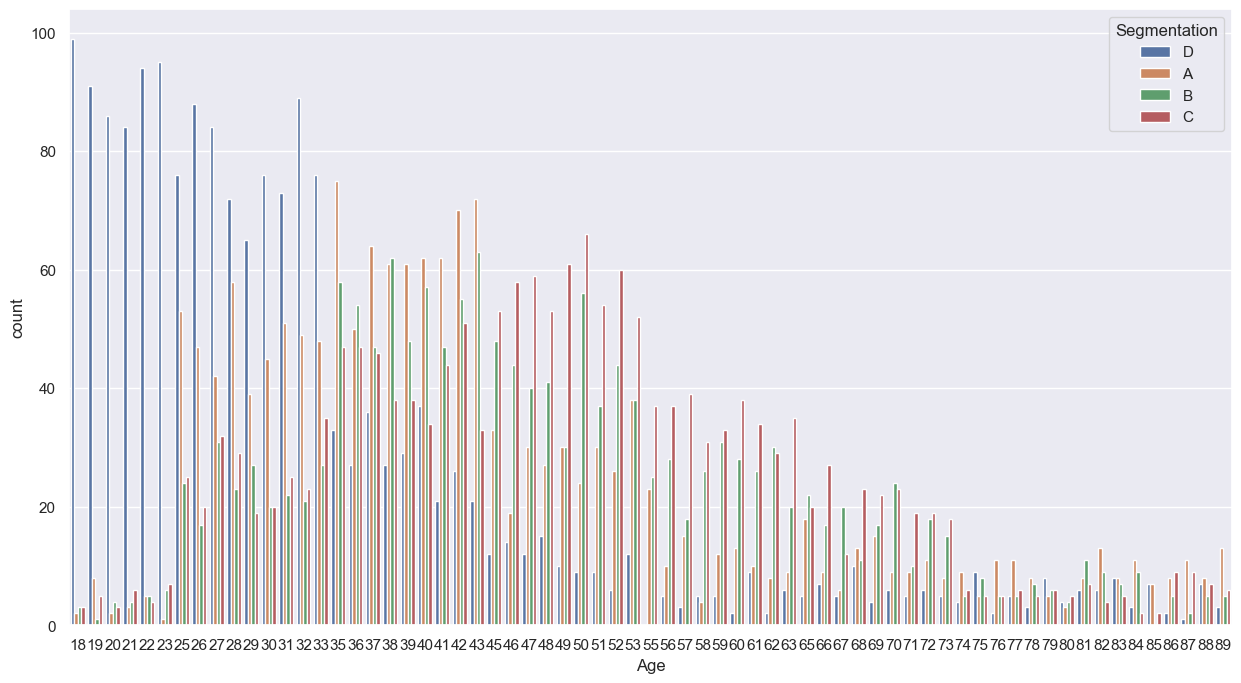

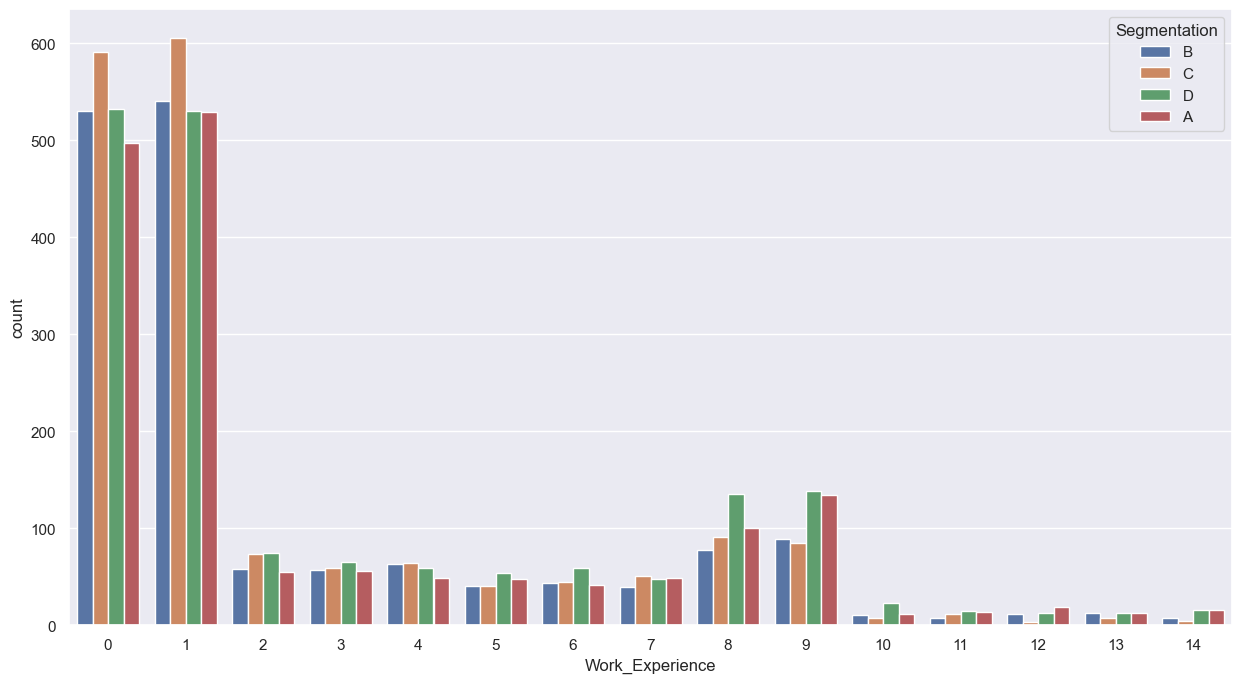

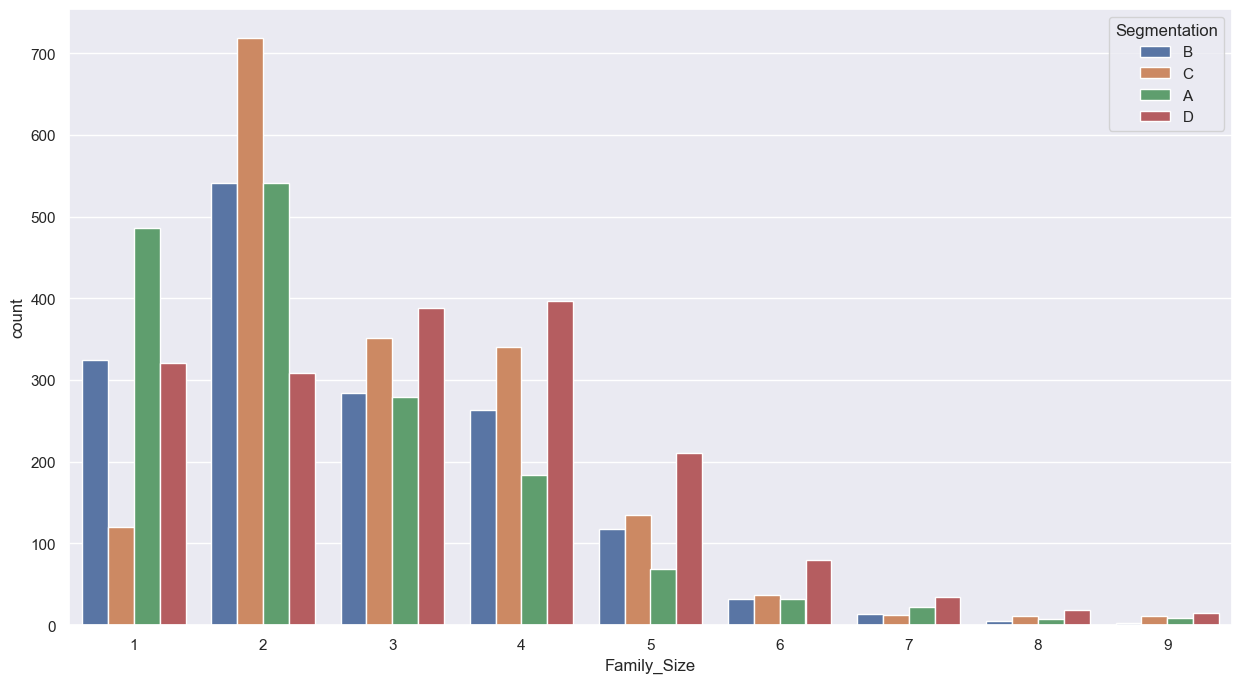

In [69]:
df['Age'] = df['Age'].astype(int)
df['Work_Experience'] = df['Work_Experience'].astype(int)
df['Family_Size'] = df['Family_Size'].astype(int)

for i, col in enumerate(floats):
    sb.countplot(df, x=col, hue='Segmentation')
    sb.set(rc={"figure.figsize": (15, 8)})
    # plt.xticks(rotation=60)
   
    plt.show()




In age, we can see the peak change as the customer get older. For the younger ages, Category D is by far the most popular. It then switches to A after the mid 30s. And then finally, to C after the mid 40s. This could mean that the age had a pretty good impact when classifying the customer, as the age itself can influence other data, such as family size, work experience, graduations and marriage.

With the work experience there is nothing itself that comes off as significant, with no large differences with the classes.

The family size seems to have correlations. Group D becomes more significant as the family size gets bigger. It could make sense as why class D also predominantly has a low spending score, since disposable income after feeing a bigger family is lower.

Now lets get our data ready for the ML model so that they'll be no issues.

The first thing is encoding the values. Some columns are categorical, meaning theres string to define it in a category. This won't work with the model as it won't be able to process words and strings.

To fix this we have a label encoder. This will take every unique category string in each column and assign it to a number. That way the model can process it since it's just a number representing a category, instead of a string.

In [70]:
for col in df.columns:
    if df[col].dtype == object:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])

In [71]:
df.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Segmentation
0,462809,1,0,22,0,5,1,2,4,3
2,466315,0,1,67,1,2,1,2,1,1
3,461735,1,1,67,1,7,0,1,2,1
5,461319,1,1,56,0,0,0,0,2,2
6,460156,1,0,32,1,5,1,2,3,2


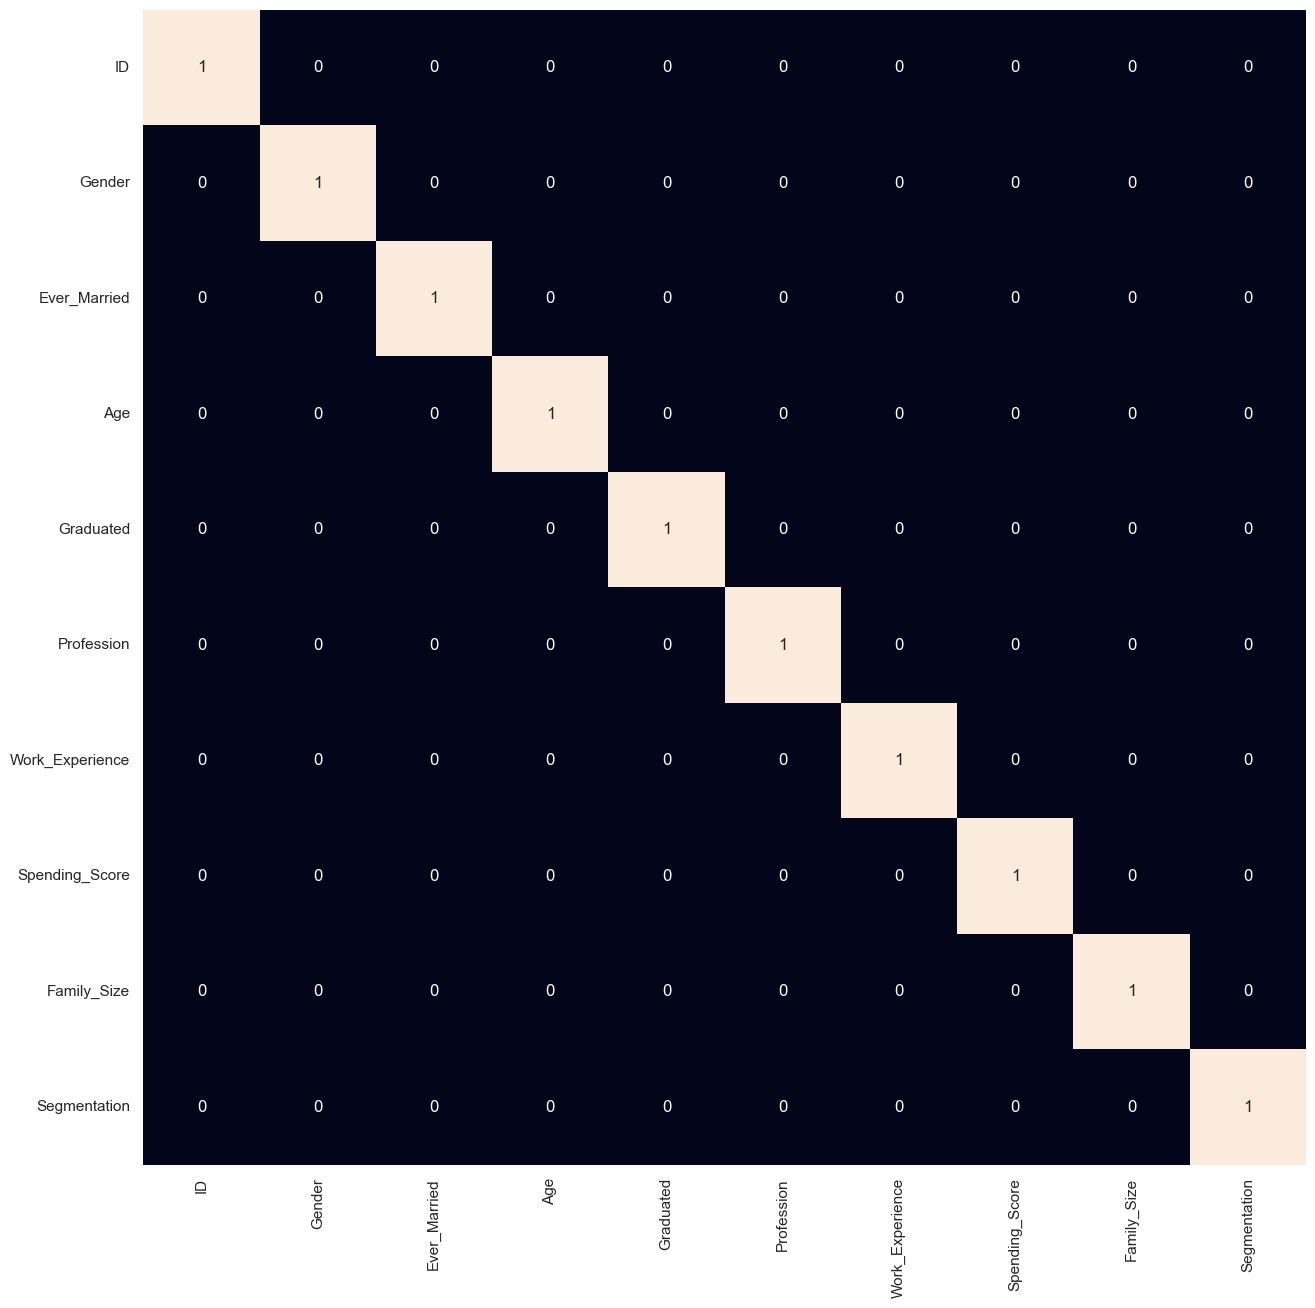

In [72]:
plt.figure(figsize=(15, 15))
sb.heatmap(df.corr() > 0.8, annot=True, cbar=False)
plt.show()

Checking this heatmap, theres no columns that share a correlation with each other, which would prove an issue since it would be pointless to use two columns that are statistically similar as one would be enough. 

In [73]:
answers = df['Segmentation']
df = df.drop(columns=['ID', 'Segmentation'])

Now we're going to use a dimensionality reduction technique called T-distributed Stochastic Neighbour Embedding (t-SNE). Dimensionality reduction is the process of transforming multi dimensional data into just 2/3 dimensions, in order for it to be visually formatted to us so we can actually visualise and asses it. 

t-SNE uses a randomised approach non-linearly. This aims to retain the structure of the dataset in the lower dimensions as well.

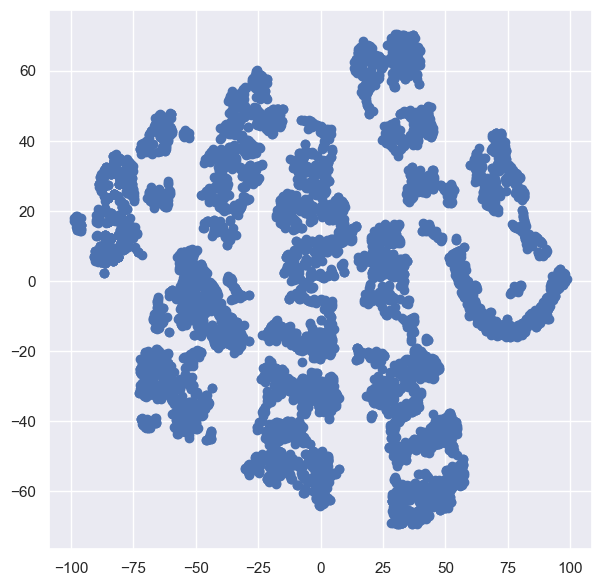

In [74]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0)
tsne_data = model.fit_transform(df)
plt.figure(figsize=(7, 7))
plt.scatter(tsne_data[:, 0], tsne_data[:, 1])
plt.show()

Here we can now visually assess the data. Clearly, there a some vertically elongdated islands in the data that can represent specific categories of customers. The aim would be to make a model that can also recognise these islands and class them as separate categories.

We will use KMeans Clusterings here to clusters the points in the higher dimensions. The way it does this is by initially selecting random K points, called cluster centroids. It then categorises each item to it's closest mean. Once done it'll update the mean coordinates and then repeated until we have the clusters that cover all the data points.

In [75]:
error = []
for n_clusters in range(1, 21):
    model = KMeans(init='k-means++',
                   n_clusters=n_clusters,
                   max_iter=500,
                   random_state=22)
    model.fit(df)
    error.append(model.inertia_)

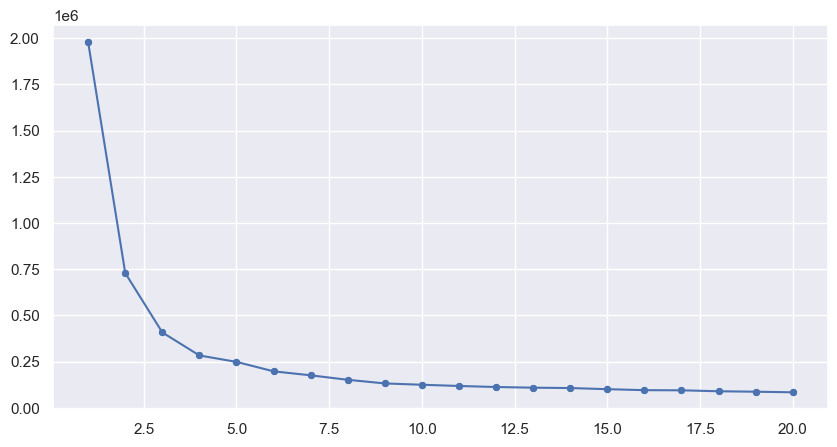

In [76]:
plt.figure(figsize=(10, 5))
sb.lineplot(x=range(1, 21), y=error)
sb.scatterplot(x=range(1, 21), y=error)
plt.show()

Here I did something called the 'Elbow method'. 

Essentially a good cluster model is one that has low inertia and a low number of clusters.

Inertia is a measurement of how well the dataset was clustered. It is calculated by measuring the distance between each data point and its centroid, squaring it, and then summing these squares across one cluster. The larger the number the larger the average distance is between the data points and its centroid, meaning its statistically not that close and thus isn't an accurate assumption.

This graphs spans the Inertia level and the number of K clusters used for each model. As we can see, as we increase the number of clusters, the level of inertia decreases rapidly at first, but then slow downs. Obviously the more K clusters we have the better, but as you increase there are multiple downside, including computational time and overfitting.

Looking at the graph, I deduce that around 6 clusters is the best, as this is where the line begins to stall out. I'll try 6 and also 5 too see how they look

In [77]:
model_6 = KMeans(init='k-means++',
               n_clusters=6,
               max_iter=500,
               random_state=22)
segments_6 = model_6.fit_predict(df)

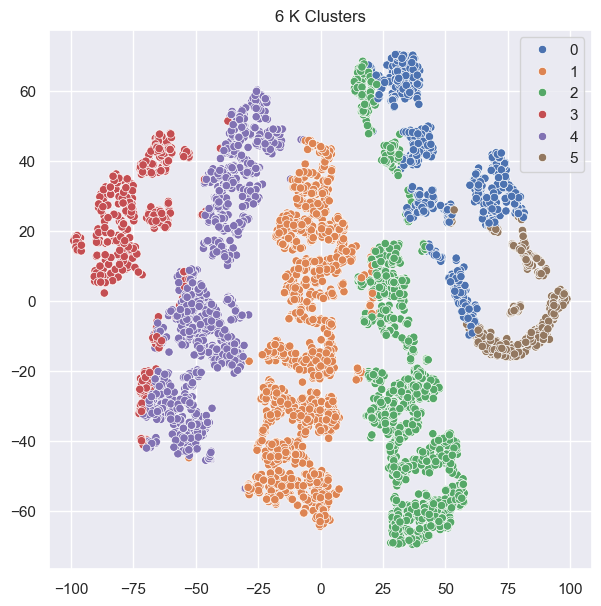

In [78]:
plt.figure(figsize=(7, 7))
sb.scatterplot(x=tsne_data[:, 0], y=tsne_data[:, 1], hue=segments_6, palette=sb.color_palette()).set(title='6 K Clusters')
plt.show()


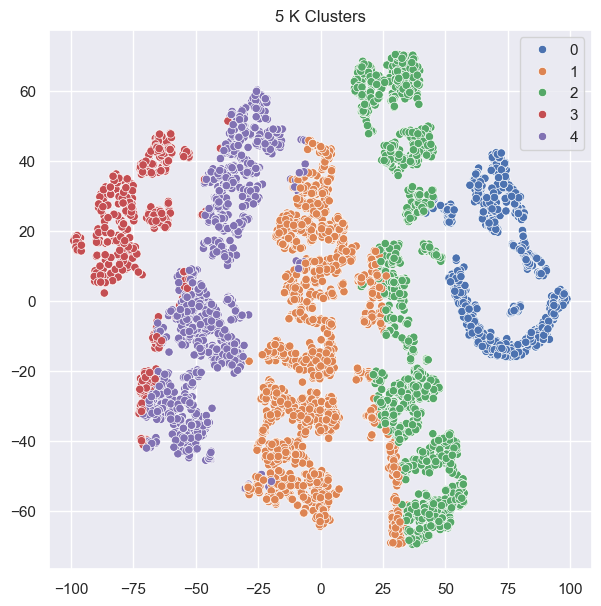

In [79]:
model_5 = KMeans(init='k-means++',
               n_clusters=5,
               max_iter=500,
               random_state=22)
segments_5 = model_5.fit_predict(df)
plt.figure(figsize=(7, 7))
sb.scatterplot(x=tsne_data[:, 0], y=tsne_data[:, 1], hue=segments_5, palette=sb.color_palette()).set(title='5 K Clusters')
plt.show()

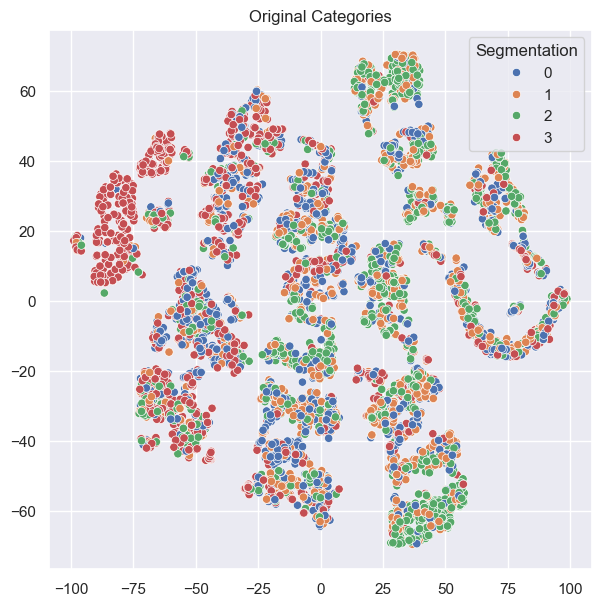

In [80]:
plt.figure(figsize=(7, 7))
sb.scatterplot(x=tsne_data[:, 0], y=tsne_data[:, 1], hue=answers, palette=sb.color_palette()).set(title='Original Categories')
plt.show()

When comparing our clustering to the original segmentation, it's clear that ours works better. The originial segmentation when visualised is a complete mess, with no real clustering to be seen and all the segmentations spread out completely. Our model however clearly identify the island to a good degree with only a few innaccuracies. 

The only issue is that some values would be classed for a cluster thats right next to the cluster it should be a part in. When comparing 5/6 clusters, I personally prefer the 6 as I see there is less datapoints being incorrectly classes when looking at it as islands. On the 5K cluster map you can see some of the yellow leak into the green class, which is not what we want. The 6K cluster doesn't have this to the same degree which is great.

Overall I am pretty happy with this. With it being my first unsupervised classifcation work, I hope in the future to try a wider range of models and well dip my feet into some hypertuning to optimise the models :)
